In [1]:
%load_ext autoreload
%autoreload 2
import torch as t
import cv2 
from model import EfficientnetWithFinetuning
from data import MelanomaData
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, f1_score, accuracy_score
from sklearn.decomposition import PCA
import random 
import pandas as pd
import seaborn as sns

plt.style.use('dark_background')
os.environ["CUDA_VISIBLE_DEVICES"]="1"

os.getcwd()

'/data_nfs/je30bery/melanoma_data/model'

In [2]:
markers = ['ADAM10', 'Bcl-2', 'CD10', 'CD107a', 'CD13', 'CD138', 'CD14', 'CD1a', 'CD2', 'CD25', 'CD271', 'CD3', 'CD36', 'CD4', 'CD44', 'CD45', 'CD45RA', 'CD45RO', 'CD5', 'CD56', 'CD6', 'CD63', 'CD66abce', 'CD7', 'CD71', 'CD8', 'CD9', 'CD95', 'Collagen IV', 'Cytokeratin-14', 'EBF-P', 'EGFR', 'EGFR-AF488', 'HLA-ABC', 'HLA-DR', 'KIP1', 'Ki67', 'L302', 'MCSP', 'Melan-A', 'Nestin-AF488', 'Notch-1', 'Notch-3', 'PPARgamma', 'PPB', 'RIM3', 'TAP73', 'Vimentin', 'p63', 'phospho-Connexin']    

In [3]:
data = "/data_nfs/datasets/melc/melanoma/processed"
vdata = [os.path.join(data, "validation", d) for d in sorted(os.listdir(os.path.join(data, "validation")))] # balance_and_shuffle(os.path.join(data, "validation"))#
tdata = [os.path.join(data, "training", d) for d in sorted(os.listdir(os.path.join(data, "training")))] # balance_and_shuffle(os.path.join(data, "validation"))#
data = vdata + tdata
dl = t.utils.data.DataLoader(MelanomaData(markers, data, mode="val"), batch_size=10) #, shuffle=True)

In [4]:
model = EfficientnetWithFinetuning(indim=len(markers))
model.load_state_dict(t.load("/data_nfs/je30bery/melanoma_data/model/saved_models/model_2023-11-20 16:27:56.558630_f1=0.9260606060606061_acc=0.9166666666666666_11.pt"))
model.eval()

/data/bionets/je30bery/anaconda3/envs/als_analysis/lib/python3.9/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


EfficientnetWithFinetuning(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(50, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): 

In [5]:
labels = np.array([int("Nevi" in d) for d in data])
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [6]:
def extract_features(model, x):
    model = model.cuda()
    x = x.cuda()
    x = model.features(x)
    x = model.avgpool(x)
    x = model.flatten(x)
    x = model.classifier1(x)    
    return x

In [7]:
it = iter(dl)

In [8]:
features = list()
while True:
    try:
        input_t, label = next(it)
    except StopIteration:
        break
    features.append(extract_features(model, input_t).detach().cpu().numpy())

In [9]:
features = np.concatenate(features)
features.shape

(197, 50)

In [20]:
num_pertubations = 1000
shilouette_scores = list()
reference_scores = list()

mel_features = features[np.where(labels==0)]

for i in range(2,11):
    kmeans = KMeans(n_clusters=i, n_init="auto")
    y = kmeans.fit_predict(mel_features)
    y_copy = y.copy()
    score = silhouette_score(mel_features, y)
    shilouette_scores.append(score)

    acc = list()
    for j in range(num_pertubations):
        random.shuffle(y)
        acc.append(silhouette_score(mel_features, y))
    reference_scores.append(score - np.array(acc))

In [21]:
gap_stat = pd.DataFrame(np.array(reference_scores).T, columns=range(2,11))

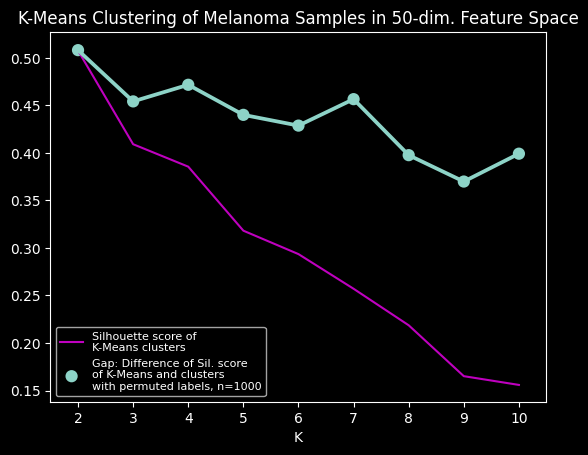

In [22]:
plt.clf()
plt.title("K-Means Clustering of Melanoma Samples in 50-dim. Feature Space")
plt.xlabel("K")
plt.plot(range(0, 9), shilouette_scores, label="Silhouette score of\nK-Means clusters", color="m")
sns.pointplot(gap_stat, label="Gap: Difference of Sil. score\nof K-Means and clusters\nwith permuted labels, n=1000")
plt.legend(fontsize="8")
#plt.savefig("Gap_Statistics.pdf")

<Axes: title={'center': 'K-Means Clustering of Melanoma Samples in 50-dim. Feature Space \n Gap Statistics'}, xlabel='K', ylabel='Gap'>

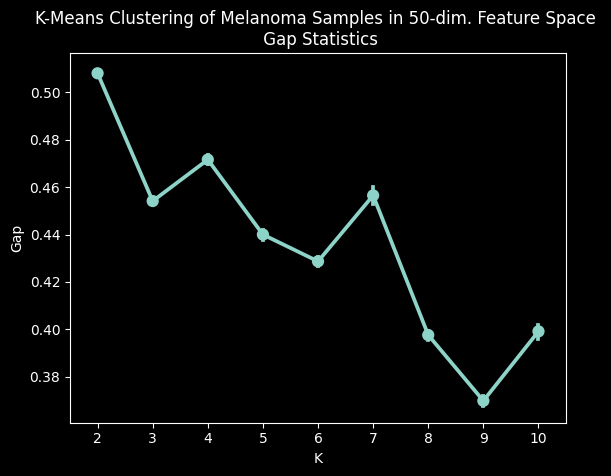

In [23]:
plt.title("K-Means Clustering of Melanoma Samples in 50-dim. Feature Space \n Gap Statistics")
plt.ylabel("Gap")
plt.xlabel("K")
sns.pointplot(gap_stat)

In [13]:
p = PCA(2)

In [14]:
transf = p.fit_transform(features)
kmeans = KMeans(n_clusters=4, n_init="auto")
y = kmeans.fit_predict(features)

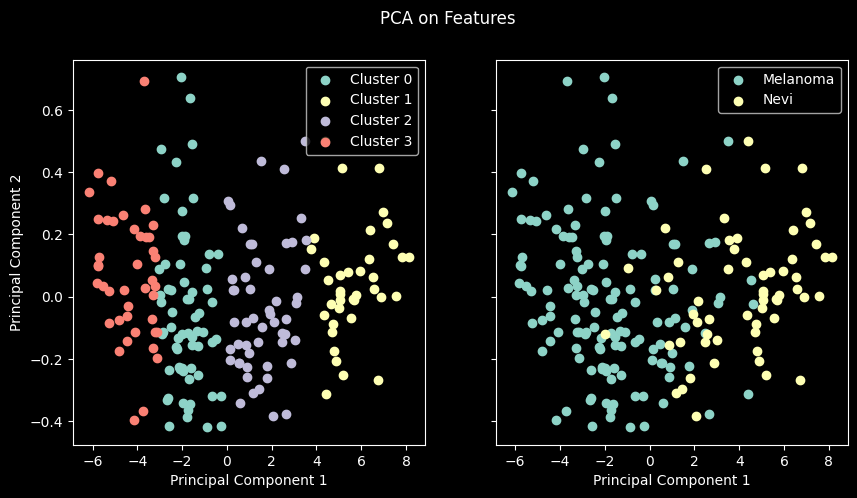

In [15]:
f, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
for c in np.unique(y):
    axs[0].scatter(transf[np.where(y == c)][:,0], transf[np.where(y == c)][:,1], label=f"Cluster {c}")
axs[0].legend()
plt.suptitle("PCA on Features")
axs[0].set_xlabel("Principal Component 1")
axs[0].set_ylabel("Principal Component 2")
axs[1].set_xlabel("Principal Component 1")


axs[1].scatter(transf[np.where(labels == 0)][:,0], transf[np.where(labels == 0)][:,1], label=f"Melanoma")
axs[1].scatter(transf[np.where(labels == 1)][:,0], transf[np.where(labels == 1)][:,1], label=f"Nevi")
axs[1].legend()

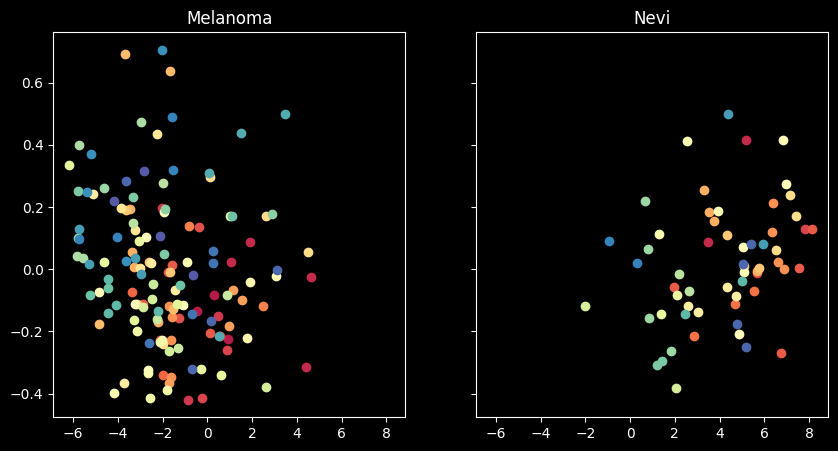

In [18]:
f, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
pal = sns.color_palette("Spectral", 42)
ids = np.array(["_".join(os.path.basename(id).split("_")[:2]) for id in data])
for i, c in enumerate(np.unique(ids)):
    if "Melanoma" in c:
        axs[0].scatter(transf[np.where(ids == c)][:,0], transf[np.where(ids == c)][:,1], label=c, color=pal[int(c.split("_")[-1])])
    else:
        axs[1].scatter(transf[np.where(ids == c)][:,0], transf[np.where(ids == c)][:,1], label=c, color=pal[int(c.split("_")[-1])*2])
plt.title("Coloring per Patient")
axs[0].set_title("Melanoma")
axs[1].set_title("Nevi")
plt.show()